<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Inversion-in-Synthetic-Data" data-toc-modified-id="Feature-Inversion-in-Synthetic-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Inversion in Synthetic Data</a></span><ul class="toc-item"><li><span><a href="#Train-Models-on-Synthetic-Data" data-toc-modified-id="Train-Models-on-Synthetic-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train Models on Synthetic Data</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Train-Standard-Model" data-toc-modified-id="Train-Standard-Model-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train Standard Model</a></span></li><li><span><a href="#Train-Adversarially-Robust-Model" data-toc-modified-id="Train-Adversarially-Robust-Model-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Train Adversarially Robust Model</a></span></li><li><span><a href="#Evaluating-Standard-and-Robust-Models" data-toc-modified-id="Evaluating-Standard-and-Robust-Models-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Evaluating Standard and Robust Models</a></span></li></ul></li><li><span><a href="#Evaluating-Input-Gradients" data-toc-modified-id="Evaluating-Input-Gradients-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Evaluating Input Gradients</a></span></li></ul></li></ul></div>

# Feature Inversion in Synthetic Data
In this notebook, we show that standard and robust fully-connected networks (FCNs) trained on a simple synthetic data distribution exhibit FIG (feature inversion in gradeints) and RF-FIG (robustness fixes FIG). The synthetic dataset comprises data points where the label $y=\pm 1$ with probability $0.5$ and $x=y \cdot e_j$ where $j$ is chosen uniformly at random from $\{1,...,d\}$. 

See Section 5 of the paper for more information about (i) the dataset and (ii) a theoretical justification that justifies our counter-intuitive empirical findings on FIG and RF-FIG. For more information about the evaluation framework, see Section 3 of our paper. Finally, to know more about obtaining attribution-masked data and retraining models on masked datasets, check out the README files and scripts in this repository.

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json 
import random
import time
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from torch import nn, optim
from robustness.model_utils import make_and_restore_model
from robustness.datasets import CIFAR

sys.path.append('scripts/')
import utils
import data_utils as du
import gpu_utils as gu
import ptb_utils as au
import misc_utils as mu
import synth_models as sm
from synthetic_data import SemiRandomSignalCoordinate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train Models on Synthetic Data
In this section, we present the code for the synthetic data (see ```get_dataset()```) and train standard and adversarially robust models on the dataset. Then, we evaluate the adversarial robustness of the standard and adversarially trained models on test data. In particular, we train a one-hidden-layer ReLU FCN with width $20000$ on a $10$-dimensional synthetic dataset with learning rate $0.1$ for $1500$ epochs, until the models obtain small standard and/or adversarial test loss.

In [35]:
def get_dataset(): 
    args = {
        'input_dim': 10,
        'num_train': 10_000,
        'num_test': 1_000,
        'batch_size': 250
    }
    
    sd_tr = SemiRandomSignalCoordinate(args['input_dim'], 1, 1./args['input_dim'])
    sd_te = SemiRandomSignalCoordinate(args['input_dim'], 1, 1./args['input_dim'])

    tr_dl = sd_tr.get_dataloader(args['num_train'], args['batch_size'])
    te_dl = sd_te.get_dataloader(args['num_test'], args['batch_size'])

    return {
        'obj': (sd_tr, sd_te),
        'loaders': (tr_dl, te_dl)
    }

def get_model(device):
    args = {
        'input_dim': 10,
        'num_classes': 2,
        'width': 20_000, 
        'depth': 1, 
        'activation': nn.ReLU,
        'lr': 0.1,
        'weight_decay': 0.0,
        'momentum': 0.0,
        'decay_gap': 50,
        'decay_factor': 0.75
    }
    
    model = sm.get_fcn(args['input_dim'], args['width'], 
                       args['num_classes'], activation=args['activation'])
    model = model.to(device)
    
    opt = optim.SGD(model.parameters(), lr=args['lr'], 
                    weight_decay=args['weight_decay'], 
                    momentum=args['momentum'])
    
    def lr_scheduler(epoch):
        pow = epoch//args['decay_gap']
        return max(0.01, args['decay_factor']**pow)

    sched = optim.lr_scheduler.LambdaLR(opt, lr_scheduler)

    return model, opt, sched

def linf_pgd_adversarial_training(train_data, test_data, epsilon, data_bounds, device):
    # setup attack
    attack = au.Linf_PGD_Attack(epsilon, lr=0.25*epsilon, num_iter=8, loss_type='untargeted', 
                                rand_eps=0.0, num_classes=2, bounds=data_bounds, device=device)

    # setup model
    model, opt, sched = get_model(device)
    
    # train for 500 epochs
    stats = utils.pgd_adv_fit_model(model, opt, train_data, test_data, attack, 
                                    sch=sched, min_loss=0.0, max_epochs=500, 
                                    device=device, epoch_gap=10)
    
    return stats, model.cpu()

### Dataset

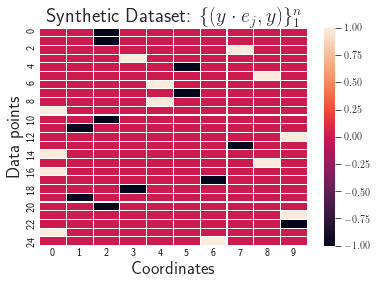

In [36]:
# visualize subsample of dataset
dataset = get_dataset()
bounds = dataset['obj'][0].bounds
train_data, test_data = dataset['loaders']

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = sns.heatmap(dataset['obj'][1].X[:25], linewidth=0.1)
utils.update_ax(ax, r'Synthetic Dataset: $\{(y\cdot e_j, y)\}^{n}_1$', 'Coordinates', 'Data points', 
                legend_loc=False, despine=False, title_fs=20, label_fs=18)

fig.savefig('plots/synthetic_data.pdf', dpi=fig.dpi, bbox_inches='tight')

### Train Standard Model

In [37]:
device = gu.get_device(0) # change 0 to None if cpu
epsilon = 0.0 # standard training

std_stats, std_model = linf_pgd_adversarial_training(train_data, test_data, epsilon, bounds, device)

Min loss: 0.0
Epoch	l-tr	a-tr	a-te	s-te	time
0   0.7087   0.9398   1.0000   1.0000   0.1352
10   0.0000   1.0000   1.0000   1.0000   1.2754
20   0.0000   1.0000   1.0000   1.0000   1.1855
30   0.0000   1.0000   1.0000   1.0000   1.3029
40   0.0000   1.0000   1.0000   1.0000   1.2244
Epoch 49, LR : 0.1 -> 0.07500000000000001
50   0.0000   1.0000   1.0000   1.0000   1.1993
60   0.0000   1.0000   1.0000   1.0000   1.2636
70   0.0000   1.0000   1.0000   1.0000   1.1757
80   0.0000   1.0000   1.0000   1.0000   1.2724
90   0.0000   1.0000   1.0000   1.0000   1.1914
Epoch 99, LR : 0.07500000000000001 -> 0.05625
100   0.0000   1.0000   1.0000   1.0000   1.1773
110   0.0000   1.0000   1.0000   1.0000   1.2539
120   0.0000   1.0000   1.0000   1.0000   1.1855
130   0.0000   1.0000   1.0000   1.0000   1.2470
140   0.0000   1.0000   1.0000   1.0000   1.1765
Epoch 149, LR : 0.05625 -> 0.0421875
150   0.0000   1.0000   1.0000   1.0000   1.2029
160   0.0000   1.0000   1.0000   1.0000   1.2973
170   0.

### Train Adversarially Robust Model

In [ ]:
device = gu.get_device(0) # change 0 to None if cpu
epsilon = 0.45 

linf_stats, linf_model = linf_pgd_adversarial_training(train_data, test_data, epsilon, bounds, device)

Min loss: 0.0
Epoch	l-tr	a-tr	a-te	s-te	time
0   29.6137   0.0171   0.0000   0.9150   0.6690
10   11.5941   0.0070   0.0000   0.6310   6.0460
20   4.1961   0.0026   0.0000   1.0000   6.1037
30   1.9347   0.0050   0.0000   1.0000   6.0384
40   1.0042   0.2249   0.2030   1.0000   6.0081
Epoch 49, LR : 0.1 -> 0.07500000000000001
50   0.6999   0.5827   0.6910   1.0000   6.0950
60   0.7062   0.4497   0.3990   1.0000   5.9285
70   0.8109   0.2257   0.0900   1.0000   6.0565
80   0.8141   0.2145   0.3030   1.0000   5.9905
90   0.8075   0.2599   0.3080   1.0000   6.0675
Epoch 99, LR : 0.07500000000000001 -> 0.05625
100   0.6746   0.6517   0.6160   1.0000   6.0146
110   0.6845   0.5665   0.3520   1.0000   6.0234
120   0.6812   0.5606   0.6600   1.0000   6.0585
130   0.7270   0.4260   0.6950   1.0000   5.9568


### Evaluating Standard and Robust Models

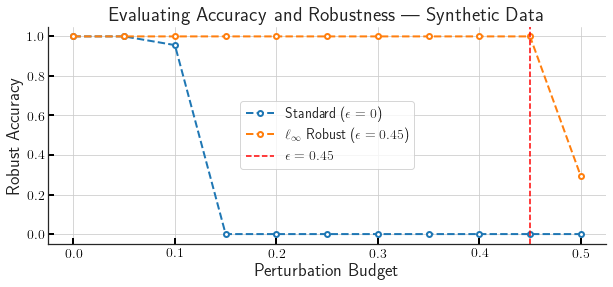

In [31]:
device = gu.get_device(0)
accs = {}
epsilons = np.linspace(0, 0.5, 11)

models = {
    r'Standard': std_model, 
    r'Robust': linf_model
}

labels = {
    'Standard': r'Standard ($\epsilon=0$)',
    'Robust': r'$\ell_{\infty}$ Robust ($\epsilon=0.45$)'
}

pgd_attack = lambda eps: au.Linf_PGD_Attack(eps, 0.25*eps, 8, 'untargeted', 
                                            rand_eps=0., num_classes=2, 
                                            bounds=bounds, device=device)

for model_name, model in models.items():
    model = model.to(device)
    accs[model_name] = mu.evaluate_robustness([model], test_data, pgd_attack, 
                                              epsilons, device, print_info=False)[0]
    model = model.cpu()
    del model
    
fig, ax = plt.subplots(1,1,figsize=(10,4))
for model_name, model_accs in accs.items():
    x, y = map(np.array, zip(*sorted(model_accs.items())))
    ax.plot(x, y, marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--', label=labels[model_name])
ax.axvline(0.45, color='red', ls='--', label=r'$\epsilon=0.45$')
utils.update_ax(ax, r'Evaluating Accuracy and Robustness | Synthetic Data', 
                r'Perturbation Budget', r'Robust Accuracy', ticks_fs=14, label_fs=18, title_fs=20)
ax.grid()
ax.legend(loc='best', ncol=1, fontsize=14, frameon=True, fancybox=True)

ax.set_ylim(-0.05,1.05)

fig.savefig('plots/synthetic_data_robustness.pdf', dpi=fig.dpi, bbox_inches='tight')

As shown above, adversarially training FCNs with $\ell_{\infty}$ perturbation budget of $\epsilon=0.45$ confers adversarial robustness at test time that is significantly more than that of standard FCNs ($\epsilon=0$). Next, we evaluate the input gradients of these two models to illustrate FIG and RF-FIG on the synthetic dataset.

## Evaluating Input Gradients
In this section, we evaluate whether input gradients of standard and adversarially 
robust models that are trained on synthetic data highlight instance-specific
features that are relevant and _necessary_ for prediction in this dataset.
We first evaluate whether top-$k$ and bottom-$k$ gradient attributions higlight
the "signal" coordinate $j$ for the data point $(y \cdot e_j, y)$. We then provide 
visualizations of the input gradients of standard and robust models, which
further substantiate FIG and RF-FIG.

In [32]:
# compute loss gradients w.r.t. input 
test_dataset = dataset['obj'][1]
device = gu.get_device(0)

grads = {}
for model_name, model in models.items():
    model = model.to(device)
    grads[model_name] = test_dataset.get_input_gradients(model, device)
    model = model.cpu()

In [33]:
# FIG: bottom-most input gradient coordinate highlights signal coordinate of data point in standard models
print ("Pr[bottom-most gradient attribution higlights signal]")

for model_name, G in grads.items():
    tracker = []
    for x, g in zip(test_dataset.X, G):
        signal_coord = np.argsort(np.abs(x))[-1]
        grad_coord = np.argsort(np.abs(g))[0]
        tracker.append(float(signal_coord==grad_coord))
    print ("{} Model: {:.3f}".format(model_name, np.mean(tracker)))

Pr[bottom-most gradient attribution higlights signal]
Standard Model: 0.850
Robust Model: 0.000


In [34]:
# RG-FIG: top-most input gradient coordinate highlights signal coordinate of data point in robust models
print ("Pr[top-most gradient attribution higlights signal]")

for model_name, G in grads.items():
    tracker = []
    for x, g in zip(test_dataset.X, G):
        signal_coord = np.argsort(np.abs(x))[-1]
        grad_coord = np.argsort(np.abs(g))[-1]
        tracker.append(float(signal_coord==grad_coord))
    print ("{} Model: {:.3f}".format(model_name, np.mean(tracker)))

Pr[top-most gradient attribution higlights signal]
Standard Model: 0.000
Robust Model: 1.000


Therefore, the attribution quality at level $k=1$ of standard and robust FCNs
is $A$ and $B$ respectively.

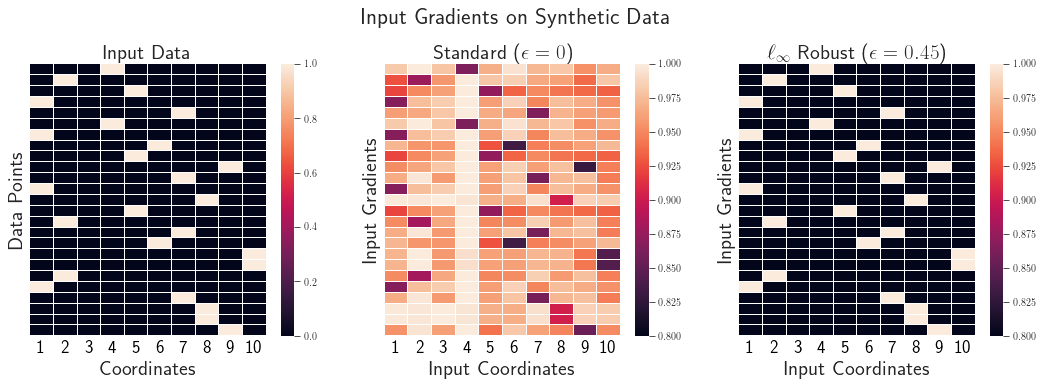

In [127]:
# visualizing input gradients of standard and robust models
fig, axs = plt.subplots(1,3,figsize=(18, 5))
xticks = np.arange(1,11)

# plot dataset
sns.heatmap(np.abs(test_dataset.X[:25]), ax=axs[0], vmin=0, 
            vmax=1, linewidth=0.01, yticklabels=False, xticklabels=xticks)
axs[0].tick_params(which='both', axis='both', length=3)
axs[0].set_xticklabels(xticks, fontsize=ticks_fs)

utils.update_ax(axs[0], title=r'Input Data', xlabel=r'Coordinates', ylabel=r'Data Points', 
                ticks_fs=ticks_fs, label_fs=label_fs, title_fs=title_fs, despine=False, legend_loc=False)

for ax, (model_name, G) in zip(axs[1:], grads.items()):
    # normalize gradients to improve visualization
    G = np.abs(G[:25])
    G /= G.max(axis=1).reshape(-1, 1)

    # plot gradients
    ax = sns.heatmap(G, ax=ax, vmax=1, vmin=0.8, linewidth=0.01, yticklabels=False, xticklabels=xticks)
    utils.update_ax(ax, title=labels[model_name], xlabel=xlabel, ylabel=r'Input Gradients', 
                    ticks_fs=ticks_fs, label_fs=label_fs, title_fs=title_fs, despine=False, legend_loc=False)

    ax.tick_params(which='both', axis='both', length=3)
    ax.set_xticklabels(xticks, fontsize=ticks_fs)
    
sup = fig.suptitle('Input Gradients on Synthetic Data', y=1.04, fontsize=23)
fig.savefig('plots/feature_inversion_synthetic_data.pdf', dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[sup])

The three subplots visualize the input data points, the input gradients of standard fully-connected network (FCN), and the input gradients of adversarially trained FCN respectively:
- The first subplot illustrates data points sampled from the synthetic distribution; the columns and rows denote input coordinates and individual data points that are sampled from the synthetic data distribution described in Section 5 of the paper.
- Ths second subplot substantiates FIG, as the minimum magnitude coordinate (darker in color) of standard input gradients often, but not always, highlights the relevant signal coordinate $j$ of the input data points. 
- The third subplot substantiates RF-FIG, as the maximum magnitude coordinate of robust input gradients consistently highlights the relevant signal coordinates. 
- As discussed in the appendix, the mean absolute cosine similarity between input and input gradients of standard and robust models are 0.29 and 1.00, indicating that unlike standard models, robust models’ input gradients are directionally (and visually) aligned with input data.